In [1]:
# Checks if the code is in a colab notebook

try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

Run on Colab notebook

In [2]:
if IN_COLAB:
  !pip install basicsr
  drive.mount('/content/drive/')
  !unzip /content/drive/MyDrive/Datasets/DIV2K_valid_HR.zip
  !unzip /content/drive/MyDrive/Datasets/DIV2K_valid_LR_clean.zip
  !unzip /content/drive/MyDrive/Datasets/DIV2K_train_LR_clean.zip
  #!unzip /content/drive/MyDrive/Datasets/DIV2K_train_HR.zip
  !unzip /content/drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/80_percent/gen_images_0.zip
  FOLDER_LR_TEST = 'DIV2K_valid_LR_clean'
  FOLDER_HR_TEST = 'DIV2K_valid_HR'
  FOLDER_LR_TRAIN = 'DIV2K_train_LR_clean'
  #FOLDER_HR_TRAIN = 'DIV2K_train_HR'
  FOLDER_GEN_IMAGES = 'gen_images_0'

  STUDENT_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/student.pth'
  STUDENT_RECORDS_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/student.csv'
  GENERATOR_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/generator.pth'
  GENERATOR_RECORDS_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/generator.csv'
  DISCRIMINATOR_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/80_percent/discriminator.pth'
  DISCRIMINATOR_RECORDS_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/80_percent/discriminator.csv'
  
  PRUNED_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\son.pth'
  FINE_TUNED_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\son_fine.pth'

  TEACHER_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/ESRGAN_models/RealESRGAN_x4plus.pth'

Run on my Windows desktop

In [3]:
if not IN_COLAB:
  FOLDER_LR_TEST = 'D:\Downloads\Div2k\DIV2K_valid_LR_clean'
  FOLDER_HR_TEST = 'D:\Downloads\Div2k\DIV2K_valid_HR'
  FOLDER_LR_TRAIN = 'D:\Downloads\Div2k\DIV2K_train_LR_clean'
  FOLDER_HR_TRAIN = 'D:\Downloads\Div2k\DIV2K_train_HR'
  
  STUDENT_MODEL_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\student.pth'
  STUDENT_RECORDS_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\student.csv'
  GENERATOR_MODEL_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\generator.pth'
  GENERATOR_RECORDS_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\generator.csv'
  DISCRIMINATOR_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\discriminator.pth'
  DISCRIMINATOR_MODEL_PATH_24 = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\discriminator_24.pth'
  DISCRIMINATOR_RECORDS_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\discriminator.csv'
  FOLDER_GEN_IMAGES = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\gen_images_0'
  
  PRUNED_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\son.pth'
  FINE_TUNED_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\son_fine.pth'
    
  SCRATCH_MODEL_PATH = f'D:\oldDrive\ML\Indiv_Project\Second_Year\ESRGAN_Scratch\model.pth'
  
  TEACHER_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\KD\ESRGAN_models\RealESRGAN_x4plus.pth'

# Setup

In [4]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
import cv2
import csv
import math
import numpy as np
import os
import queue
import threading
from basicsr.archs.rrdbnet_arch import RRDBNet as RRDBNetOriginal
import torchvision
from os import listdir, environ, path
from pathlib import Path
from PIL import Image
import matplotlib as mpl
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
from torchvision.models import vgg19
from ignite.metrics import PSNR, SSIM
from ignite.engine import Engine
import pandas as pd
from functools import reduce

# Making sure to use the gpu, if available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_device(torch.device(0))

C:\Users\Vincent\anaconda3\envs\ai-robotics\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.L1Loss()
        self.vgg = vgg19(weights='DEFAULT').features[:35].eval().to(DEVICE)
        
        for param in self.vgg.parameters():
            param.requires_grad = False
    
    def forward(self, X, y):
        vgg_input_features = self.vgg(X)
        vgg_target_features = self.vgg(y)
        return self.loss(vgg_input_features, vgg_target_features)



class ConvBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, use_act: bool, **kwargs):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
    self.activation = nn.LeakyReLU(.2, inplace=True) if use_act else nn.Identity()

  def forward(self, x):
    return self.activation(self.conv(x))

class RDB(nn.Module):
  def __init__(self, in_channels, middle_channels = 32, residual_scale = .2):
    super().__init__()
    self.residual_scale = residual_scale
    self.block = nn.ModuleList([ConvBlock(in_channels + i * middle_channels,
                                  middle_channels if i<4 else in_channels,
                                  3,
                                  stride=1,
                                  padding=1,
                                  use_act=i<4) for i in range(5)])


  def forward(self, x):
    input = x
    for conv in self.block:
      out = conv(input)
      input = torch.cat([input, out], dim=1)
    return self.residual_scale * out + x

class RRDB(nn.Module):
  def __init__(self, in_channels, mid_channels = 32, residual_scale = .2):
    super().__init__()
    self.residual_scale = residual_scale
    self.model = nn.Sequential(*[RDB(in_channels, middle_channels = mid_channels, residual_scale = residual_scale) for _ in range(3)])
  
  def forward(self, x):
    return self.model(x) * self.residual_scale + x

class Head(nn.Module):
  def __init__(self, out_channels = 64) -> None:
    super().__init__()
    self.model = nn.Conv2d(3, out_channels, 3, stride=1, padding=1)

  def forward(self, x):
    return self.model(x)

class Tail(nn.Module):
  def __init__(self, in_channels = 64) -> None:
    super().__init__()
    self.model = nn.Sequential(nn.Conv2d(in_channels, 256, 3, stride=1, padding=1),
                               nn.Upsample(scale_factor=4, mode='nearest'),
                               nn.LeakyReLU(.2, inplace=True),
                               nn.Conv2d(256, 3, 3, stride=1, padding=1))
  
  def forward(self, x):
    return self.model(x)

# Original code for ESRGAN:
# https://github.com/xinntao/ESRGAN/blob/master/RRDBNet_arch.py

import functools
import torch
import torch.nn as nn
import torch.nn.functional as F


def make_layer(block, n_layers, **kwargs):
    layers = []
    for _ in range(n_layers):
        layers.append(block(**kwargs))
    return nn.Sequential(*layers)


class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        # mutil.initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x


class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x


class RRDBNet(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, nf=64, nb=23, gc=32):
        super(RRDBNet, self).__init__()

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB, nb, nf=nf, gc=gc)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        #### upsampling
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        feat = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(feat))
        feat = feat + trunk

        feat = self.lrelu(self.upconv1(F.interpolate(feat, scale_factor=2, mode='nearest')))
        feat = self.lrelu(self.upconv2(F.interpolate(feat, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(feat)))

        return out

In [6]:
class DIV2KEval(object):
    def __init__(self, folder, res_size: int = 48):
        self.folder = folder
        self.image_names = sorted(listdir(folder))
        self.len = len(self.image_names)
        if res_size < 1:
            self.resize = nn.Identity()
        else:
            self.resize = torchvision.transforms.Resize(res_size)
            
    def get_image_path(self, index: int):
        return Path(self.folder).joinpath(self.image_names[index])
        
    def get_image(self, index: int):
        image = Image.open(self.get_image_path(index))
        return torchvision.transforms.ToTensor()(image)
    
    def __getitem__(self, index: int):
        # Get the right target image because we will use it resized version as input for the model
        image = self.get_image(index)
        return (self.resize(image),)
    
    def __len__(self):
        return self.len

    def restrict_size(self, size):
        if size <= len(self.image_names) and size > 0:
            self.len = size
        else:
            self.len = len(self.image_names)
            print(f"Size must be between 0 and {len(self.image_names)}")
            
class DivideBy4Eval(DIV2KEval):
    def __init__(self, folder):
        super().__init__(folder, 0)
        self.resize = None
    
    def __getitem__(self, index: int):
        image = self.get_image(index)
        width, height = image.shape[-2:]
        X = torchvision.transforms.Resize((width//4, height//4))(image)
        y = torchvision.transforms.Resize((width - width % 4, height - height % 4))(image)
        return X, y

class DIV2KTrain(DIV2KEval):
    def __init__(self,  high_res_folder, low_res_size: int = 48, hr_resize_factor = 3):
        # We setup the HR folder and and (possible) resize as the basis for the parent class
        #
        # smallest dim: ~600 - We don't want to resize over 648 pixels because the smallest dimension of our
        # training HR images is 648px. We don't want the target image to have experienced any kind of super-resolution.
        crop_size = low_res_size*4
        
        # hr_target_size
        super().__init__(high_res_folder, int(crop_size * hr_resize_factor))
        
        self.crop_size = crop_size
        
        # smallest dim: 48
        self.resize_lr = torchvision.transforms.Resize(low_res_size)

  
    def __getitem__(self, i):
        # Get the right target image because we will use it resized version as input for the model
        target = self.get_image(i)

        # The images having a resolution of 2040 pixels make it hard for our cropping of 48*4=192 pixels
        # to mimic a genuine image despite its advantage of showing great detailing.
        # Mainly because we only use a very small area of the image:
        #     (192*192)/(2040*1300) = 2%, in the case of an image with a smaller dimension of 1300 pixels.
        # This is why we introduce croppings of resized images that will capture more the elements of the HR image.
        #     (192*192)/(582*371) = 17%, if we divide the original proportions by 3.5
        # However, there is still a compromise between the loss of information induced when resizing the HR image down
        # and the amount of elements we retain when cropping the original image.
        # Hence why we use multiple scales when extracting these croppins.

        # This probablity is prone to decrease as the model gains more performance (with smaller learning rate)
        if torch.rand(1).item() < .99:
            # Resize the full image
            target = self.resize(target) 

        # Crop of target image
        x, y, h, w = torchvision.transforms.RandomCrop.get_params(target, output_size=(self.crop_size, self.crop_size))
        target = torchvision.transforms.functional.crop(target, x, y, h, w)

        # Resizing for input image
        img = self.resize_lr(target)

        return img, target

# Only loads one every n images in a folder
class SelectiveEval(DIV2KEval):
    def __init__(self, folder, res_size: int = 48, step: int = 2, start_modulo: int = 0):
        super().__init__(folder, res_size)
        self.step = step
        self.start_modulo = start_modulo % step
        self.len = len(self.image_names)//self.step
    
    def get_image_path(self, index: int):
        return Path(self.folder).joinpath(self.image_names[self.start_modulo + self.step * index])
    
    def restrict_size(self, size):
        if size > len(self.image_names):
            print(f"Size must be between 0 and {len(self.image_names)}")
        elif size < 0:
            self.len = len(self.image_names)//self.step
        else:
            self.len = size


class CombinedEval(DIV2KEval):
    def __init__(self, folders, resize: bool = True):
        assert len(folders) > 0, 'Folders cannot be empty'
        super().__init__(folders[0], 0)
        self.resize = None
        self.folders = folders
        self.image_names = [sorted(listdir(folder)) for folder in folders]
        self.lengths = [len(folder_images) for folder_images in self.image_names]
        self.len = sum(self.lengths)
        
    def convert_index(self, index: int):
        folder = 0
        while folder < len(self.image_names) and not index < self.lengths[folder]:
            index -= self.lengths[folder]
            folder += 1
        return folder,index
    
    def get_image_path(self, index: int):
        folder, index = self.convert_index(index)
        return Path(self.folders[folder]).joinpath(self.image_names[folder][index])
        
    def get_image(self, index: int):
        image = Image.open(self.get_image_path(index))
        return torchvision.transforms.ToTensor()(image)
    
    def __getitem__(self, index: int):
        image = self.get_image(index)
        width, height = image.shape[-2:]
        X = torchvision.transforms.Resize((width//4, height//4))(image)
        y = torchvision.transforms.Resize((width - width % 4, height - height % 4))(image)
        return X, y
    
    def restrict_size(self, size):
        if size < sum(self.lengths) and size > 0:
            self.len = size
        else:
            self.len = sum(self.lengths)
            print(f"Size must be between 0 and {sum(self.lengths)}")

# Evaluation Setup

In [7]:
class Evaluator():
    def __init__(self, tile_size: int = 450, tile_pad: int = 10, pre_pad: int = 10):
        self.toPIL = torchvision.transforms.ToPILImage()
        self.tile_size = tile_size
        self.tile_pad = tile_pad
        self.pre_pad = pre_pad
    
    def enhance(self, model: nn.Module, image: torch.Tensor) -> torch.Tensor:
        model.to(DEVICE)
        model.eval()
        #if len(image.shape) == 3:
        #    image = image.unsqueeze(dim=0).to(DEVICE)
        #return model(image)[0].clamp_(0.,1.)
        return self.tile_process(model, image)
    
    def tile_process(self, model: nn.Module, img: torch.Tensor):
        """It will first crop input images to tiles, and then process each tile.
        Finally, all the processed tiles are merged into one images.
        Modified from: https://github.com/ata4/esrgan-launcher
        """
        channel, height, width = img.shape
        output_height = height * 4
        output_width = width * 4
        output_shape = (channel, output_height, output_width)

        # start with black image
        output = img.new_zeros(output_shape)
        tiles_x = math.ceil(width / self.tile_size)
        tiles_y = math.ceil(height / self.tile_size)

        # loop over all tiles
        for y in range(tiles_y):
            for x in range(tiles_x):
                # extract tile from input image
                ofs_x = x * self.tile_size
                ofs_y = y * self.tile_size
                # input tile area on total image
                input_start_x = ofs_x
                input_end_x = min(ofs_x + self.tile_size, width)
                input_start_y = ofs_y
                input_end_y = min(ofs_y + self.tile_size, height)

                # input tile area on total image with padding
                input_start_x_pad = max(input_start_x - self.tile_pad, 0)
                input_end_x_pad = min(input_end_x + self.tile_pad, width)
                input_start_y_pad = max(input_start_y - self.tile_pad, 0)
                input_end_y_pad = min(input_end_y + self.tile_pad, height)

                # input tile dimensions
                input_tile_width = input_end_x - input_start_x
                input_tile_height = input_end_y - input_start_y
                tile_idx = y * tiles_x + x + 1
                input_tile = img[:, input_start_y_pad:input_end_y_pad, input_start_x_pad:input_end_x_pad]

                # upscale tile
                try:
                    with torch.no_grad():
                        output_tile = model(input_tile.unsqueeze(dim=0).to(DEVICE))[0]
                except RuntimeError as error:
                    print('Error', error)
                print(f'\tTile {tile_idx}/{tiles_x * tiles_y}')

                # output tile area on total image
                output_start_x = input_start_x * 4
                output_end_x = input_end_x * 4
                output_start_y = input_start_y * 4
                output_end_y = input_end_y * 4

                # output tile area without padding
                output_start_x_tile = (input_start_x - input_start_x_pad) * 4
                output_end_x_tile = output_start_x_tile + input_tile_width * 4
                output_start_y_tile = (input_start_y - input_start_y_pad) * 4
                output_end_y_tile = output_start_y_tile + input_tile_height * 4

                # put tile into output image
                output[:, output_start_y:output_end_y,
                            output_start_x:output_end_x] = output_tile[:, output_start_y_tile:output_end_y_tile,
                                                                       output_start_x_tile:output_end_x_tile]
        return output.clamp_(0.,1.)
    
    # The dataset is an extension of the DIV2KEval
    def run_on_dataset(self, model: nn.Module, dataset: DIV2KEval, folder: str = None):
        for index in range(len(dataset)):
            # Enhance image
            output = self.enhance(model, dataset[index][0])
            
            if folder:
                # Save it into the right folder
                #print(Path(folder).joinpath(f'{index+1:04d}.png'))
                self.toPIL(output).save(Path(folder).joinpath(f'{index+1:04d}.png'))
    
    def baseline_on_dataset(self, method_id: int, dataset: DIV2KEval, folder: str = None):
        for index in range(len(dataset)):
            # Enhance image
            img = self.toPIL(dataset[index][0])
            width, height = img.size
            img = img.resize((width*4, height*4), method_id)
            
            if folder:
                # Save it into the right folder
                # print(Path(folder).joinpath(f'{index+1:04d}.png'))
                img.save(Path(folder).joinpath(f'{index+1:04d}.png'))
    
    def calculate_metrics(self, dataset_g: DIV2KEval, dataset_t: DIV2KEval, record_folder: str):
        for j in range(len(dataset_g)):
            filename = dataset_g.get_image_path(j)
            
            def process_function(engine, batch):
                return batch[0], batch[1]
            
            engine = Engine(process_function)
            psnr_metric = PSNR(data_range=1.0)
            ssim_metric = SSIM(data_range=1.0)
            
            ssim_metric.attach(engine, 'ssim')
            psnr_metric.attach(engine, 'psnr')
            
            generated = dataset_g[j][-1].unsqueeze(dim=0)
            target = dataset_t[j][-1].unsqueeze(dim=0)
            state = engine.run([[generated, target]])
            
            psnr, ssim = state.metrics['psnr'], state.metrics['ssim']
            
            #print([filename, psnr, ssim])
            
            with open(record_path, 'a', newline='') as f:
                csv.writer(f).writerow([filename, psnr, ssim])
            


# Evaluation

Used the pretrained, pruned and trained from scratch to enhance images from the evaluaion sets. Saved the results in respective folders.

In [8]:
TESTING = False
EVALUATED = True

In [9]:
OUT_FOLDER = 'E:\\Images\\Super-resolution\\'
IN_FOLDER = 'D:\\Downloads\\'
MODELS = ['Scratch', 'Pretrained', 'Pruned']
MODEL_PATHS = [SCRATCH_MODEL_PATH, TEACHER_MODEL_PATH, FINE_TUNED_MODEL_PATH]
MODEL_KEYS = ['model_state_dict', 'params_ema', 'state_dict']

#MODELS = MODELS[:1]

DATASETS = ['Set5', 'Set14', 'Urban100', 'BSD100', 'BSD300', 'DIV2K_clean', 'DIV2K_mild', 'DIV2K_wild', 'DIV2K_difficult']
DATASET_LOADERS = [DivideBy4Eval(Path(IN_FOLDER).joinpath('Set5')),
                   DivideBy4Eval(Path(IN_FOLDER).joinpath('Set14')),
                   SelectiveEval(Path(IN_FOLDER).joinpath('Urban100\image_SRF_4'), 0, start_modulo=1),
                   SelectiveEval(Path(IN_FOLDER).joinpath('BSD100\image_SRF_4'), 0, start_modulo=1),
                   CombinedEval([r'D:\Downloads\BSD300\images\test', r'D:\Downloads\BSD300\images\train']),
                   DIV2KEval(Path(IN_FOLDER).joinpath('Div2k\\DIV2K_valid_LR_clean'), 0),
                   DIV2KEval(Path(IN_FOLDER).joinpath('Div2k\\DIV2K_valid_LR_mild'), 0),
                   DIV2KEval(Path(IN_FOLDER).joinpath('Div2k\\DIV2K_valid_LR_wild'), 0),
                   DIV2KEval(Path(IN_FOLDER).joinpath('Div2k\\DIV2K_valid_LR_difficult'), 0)]

evaluator = Evaluator()

if not EVALUATED:
    for i in range(len(MODELS)):
        print('*****************************************************************')
        model_name = MODELS[i]
        model_path = MODEL_PATHS[i]
        model_key = MODEL_KEYS[i]
        print(model_name)

        if model_name == 'Scratch':
            model = RRDBNet()
        else:
            model = RRDBNetOriginal(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
        saved_info = torch.load(model_path, map_location=torch.device('cpu'))
        model.load_state_dict(saved_info[model_key])
        model.to(DEVICE)
        for j in range(len(DATASETS)):
            dataset_name = DATASETS[j]
            print(dataset_name)

            # initialize datasets

            dataset = DATASET_LOADERS[j]

            if TESTING:
                dataset.restrict_size(1)
            else:
                dataset.restrict_size(-1)

            evaluator.run_on_dataset(model, dataset, Path(OUT_FOLDER).joinpath(model_name).joinpath(dataset_name))

Used the nearest neighbour, bilinear and bicubic interpolation to enhance images from the evaluaion sets. Saved the results in respective folders.

In [10]:
OUT_FOLDER = 'E:\\Images\\Super-resolution\\'
IN_FOLDER = 'D:\\Downloads\\'

METHOD_NAME = ['Nearest_Neighbour', 'Bilinear', 'Bicubic']

DATASETS = ['Set5', 'Set14', 'Urban100', 'BSD100', 'BSD300', 'DIV2K_clean', 'DIV2K_mild', 'DIV2K_wild', 'DIV2K_difficult']
DATASET_LOADERS = [DivideBy4Eval(Path(IN_FOLDER).joinpath('Set5')),
                   DivideBy4Eval(Path(IN_FOLDER).joinpath('Set14')),
                   SelectiveEval(Path(IN_FOLDER).joinpath('Urban100\image_SRF_4'), 0, start_modulo=1),
                   SelectiveEval(Path(IN_FOLDER).joinpath('BSD100\image_SRF_4'), 0, start_modulo=1),
                   CombinedEval([r'D:\Downloads\BSD300\images\test', r'D:\Downloads\BSD300\images\train']),
                   DIV2KEval(Path(IN_FOLDER).joinpath('Div2k\\DIV2K_valid_LR_clean'), 0),
                   DIV2KEval(Path(IN_FOLDER).joinpath('Div2k\\DIV2K_valid_LR_mild'), 0),
                   DIV2KEval(Path(IN_FOLDER).joinpath('Div2k\\DIV2K_valid_LR_wild'), 0),
                   DIV2KEval(Path(IN_FOLDER).joinpath('Div2k\\DIV2K_valid_LR_difficult'), 0)]

evaluator = Evaluator()
if not EVALUATED:
    for j in range(len(DATASETS)):
        print('*****************************************************************')
        dataset_name = DATASETS[j]
        print(dataset_name)

        # initialize datasets

        dataset = DATASET_LOADERS[j]

        for i in range(len(METHOD_NAME)):
            method_name = METHOD_NAME[i]
            print(method_name)

            if TESTING:
                dataset.restrict_size(1)
            else:
                dataset.restrict_size(-1)
            
            evaluator.baseline_on_dataset(i, dataset, Path(OUT_FOLDER).joinpath(method_name).joinpath(dataset_name))

print('Done')

Done


Records the PSNR and SSIM values of all papers

In [11]:
OUT_FOLDER = 'E:\\Images\\Super-resolution\\'
IN_FOLDER = 'D:\\Downloads\\'

DATASETS = ['Set5', 'Set14', 'Urban100', 'BSD100', 'BSD300', 'DIV2K_clean', 'DIV2K_mild', 'DIV2K_wild', 'DIV2K_difficult']

TARGET_FOLDERS = [DivideBy4Eval(Path(IN_FOLDER).joinpath('Set5')),
                  DivideBy4Eval(Path(IN_FOLDER).joinpath('Set14')),
                  SelectiveEval(Path(IN_FOLDER).joinpath('Urban100\image_SRF_4'), 0, start_modulo=0),
                  SelectiveEval(Path(IN_FOLDER).joinpath('BSD100\image_SRF_4'), 0, start_modulo=0),
                  CombinedEval([r'D:\Downloads\BSD300\images\test', r'D:\Downloads\BSD300\images\train']),
                  DIV2KEval(Path(IN_FOLDER).joinpath('Div2k\\DIV2K_valid_HR'), 0),
                  DIV2KEval(Path(IN_FOLDER).joinpath('Div2k\\DIV2K_valid_HR'), 0),
                  DIV2KEval(Path(IN_FOLDER).joinpath('Div2k\\DIV2K_valid_HR'), 0),
                  DIV2KEval(Path(IN_FOLDER).joinpath('Div2k\\DIV2K_valid_HR'), 0)]

def get_generated_dataset(method_dir):
    return [DivideBy4Eval(Path(OUT_FOLDER).joinpath(method_dir).joinpath('Set5')),
            DivideBy4Eval(Path(OUT_FOLDER).joinpath(method_dir).joinpath('Set14')),
            DivideBy4Eval(Path(OUT_FOLDER).joinpath(method_dir).joinpath('Urban100')),
            DivideBy4Eval(Path(OUT_FOLDER).joinpath(method_dir).joinpath('BSD100')),
            DivideBy4Eval(Path(OUT_FOLDER).joinpath(method_dir).joinpath('BSD300')),
            DIV2KEval(Path(OUT_FOLDER).joinpath(method_dir).joinpath('DIV2K_clean'), 0),
            DIV2KEval(Path(OUT_FOLDER).joinpath(method_dir).joinpath('DIV2K_mild'), 0),
            DIV2KEval(Path(OUT_FOLDER).joinpath(method_dir).joinpath('DIV2K_wild'), 0),
            DIV2KEval(Path(OUT_FOLDER).joinpath(method_dir).joinpath('DIV2K_difficult'), 0)]

evaluator = Evaluator()

methods = sorted(listdir(OUT_FOLDER))
#methods = ['Scratch']

if not EVALUATED:
    for method in methods:
        print(method)
        datasets = DATASETS
        generated_datasets = get_generated_dataset(method)
        for index in range(len(datasets)):
            dataset_name = datasets[index]
            dataset_t = TARGET_FOLDERS[index]
            dataset_g = generated_datasets[index]

            # Get name of record file
            record_path = f'{Path(OUT_FOLDER).joinpath(method).joinpath(dataset_name)}.csv'
            #print(record_path)

            with open(record_path, 'w', newline='') as f:
                csv.writer(f).writerow(['filename', 'PSNR', 'SSIM'])

            if TESTING:
                dataset_g.restrict_size(1)
                dataset_t.restrict_size(1)
            else:
                dataset_g.restrict_size(-1)
                dataset_t.restrict_size(-1)

            
            evaluator.calculate_metrics(dataset_g, dataset_t, record_path)

Processing of recorded metrics

In [12]:
OUT_FOLDER = 'E:\\Images\\Super-resolution\\'

DATASETS = ['Set5', 'Set14', 'Urban100', 'BSD100', 'BSD300', 'DIV2K_clean', 'DIV2K_mild', 'DIV2K_wild', 'DIV2K_difficult']

class ResultsContainer:
    def __init__(self, name: str):
        self.name = name
        self.data = []
        self.metrics = ['PSNR', 'SSIM']
        # Here are the averages per dataset for a given method
        # The keys are the metrics and the values are the averages
        self.means = {}
        # Holds the names of the datasets
        self.datasets = []
    
    def __getitem__(self, index: int):
        return self.data[index]
    
    def append(self, dataset_name, obj):
        self.data.append(obj)
        self.datasets.append(dataset_name)
        self.update_means()
    
    def __len__(self):
        return len(self.data)
    
    def update_means(self):
        for metric in self.metrics:
            self.means[metric] = [df.mean(numeric_only=True)[metric] for df in self.data]
    
###########################################################################################################################

class EvalResults:
    def __init__(self):
        self.method_names = sorted(listdir(OUT_FOLDER))
        self.methods = []
        self.metrics = ['PSNR', 'SSIM']
        # Means per metric and method
        # means[metric] = [mean1, mean2,...]
        self.means = {}
        self.colormap_method = mpl.colormaps['seismic']
        
    def __getitem__(self, index: int):
        return self.methods[index]
    
    def __len__(self):
        return len(self.methods)
    
    def update_means(self):
        for metric in self.metrics:
            self.means[metric] = [sum(self[method_id].means[metric])/len(DATASETS) for method_id in range(len(self.method_names))]
    
    def load(self):
        self.methods = []
        for method in self.method_names:
            method_results = ResultsContainer(method)
            for dataset in DATASETS:
                filename = f'{Path(OUT_FOLDER).joinpath(method).joinpath(dataset)}.csv'
                method_results.append(dataset, pd.read_csv(filename))
            self.methods.append(method_results)
        self.update_means()
    
    # compared_names: iter
    #     -> list of names of the feature to be compared (ex: [bilinear,...])
    # compared_on_names: iter
    #    -> list of names of the feature to be used for comparison (ex: [Set5,...])
    # ids: iter
    #    -> list of indexes of specific elements to be compared (ex: [0,5] respective positions in compared_names)
    # get_data_mean(i, id__compared, id__compared_on):
    #    -> function to get the mean value of the points of compared feature on the compared_on given the metric i
    #        (ex: mean of Bilinear over Set5)
    # get_data_values(i, id__compared, id__compared_on):
    #    -> function to get all values of compared feature on the compared_on given the metric i
    #        (ex: all values of Bilinear over Set5)
    # limit: int
    #    -> limit on number of compared elements after which we disable the distribution visuals
    
    def backbone_visualize(self,
                           compared_names: iter,
                           compared_on_names: iter,
                           ids: iter,
                           get_data_mean,
                           get_data_values,
                           limit: int = 1,
                           colormap_compared = mpl.colormaps['tab20b'],
                           colormap_compared_on = mpl.colormaps['tab20b']):
        names = [compared_names[i] for i in ids]
        
        display_values = len(ids) < limit + 1
        
        # Figure for averages
        fig1, axes1 = plt.subplots(2 if display_values else 1, 1, figsize=(7,10) if display_values else (5,5))
        # Figure for all values
        fig2, axes2 = plt.subplots(2 if display_values else 1, 1, figsize=(7,10) if display_values else (5,5))
        ax_container = [axes1, axes2]
        
        fig1.tight_layout(pad=3.0)
        fig2.tight_layout(pad=3.0)
        
        for i in range(len(self.metrics)):
            # Styling
            # Averages
            if display_values:
                axes = ax_container[i]
                tmp = 0
            else:
                axes = ax_container
                tmp = i
            
            axes[tmp].set_xlabel(self.metrics[i])
            axes[tmp].set_title(f'{self.metrics[i]} averages for {", ".join(names)}')
            axes[tmp].set_yticklabels(names)
            axes[tmp].set_yticks(np.arange(0, len(names)))
            axes[tmp].grid(linestyle="--", linewidth=0.5, color='gray', zorder=-10)
            axes[tmp].set_ylim(-1,len(names) + 2)

            if display_values:
                # All values
                axes[1].set_xlabel(self.metrics[i])
                axes[1].set_title(f'All {self.metrics[i]} values for {", ".join(names)}')
                axes[1].set_yticklabels(compared_on_names)
                axes[1].set_yticks(np.arange(0, len(compared_on_names)*(len(ids)+1), (len(ids)+1)))
                axes[1].grid(linestyle="--", linewidth=0.5, color='gray', zorder=-10)
                axes[1].set_ylim(-1, len(compared_on_names)*(len(ids)+1) + len(ids)*2)
            
            
            for id__compared_on in range(len(compared_on_names)):
                # plot average by compared on feature
                means = [get_data_mean(i, ids[id_c], id__compared_on) for id_c in range(len(ids))]
                color_ratio_c_o = id__compared_on/(len(compared_on_names)-1)
                axes[tmp].scatter(means, np.arange(0,len(means)), label=compared_on_names[id__compared_on], color=colormap_compared_on(color_ratio_c_o), zorder=2)
                
                for j in range(len(ids)):
                    id__compared = ids[j]

                    # all values
                    all_values = get_data_values(i, id__compared, id__compared_on)
                    pos = id__compared_on*(len(ids)+1)+j
                    color_ratio_c = id__compared/(len(compared_names)-1)
                    
                    if display_values:
                        vp = axes[1].violinplot(all_values, positions=[pos], vert=False, showmeans=True)
                        for k,v in vp.items():
                            if k == 'bodies':
                                v[0].set_facecolor(colormap_compared(color_ratio_c))
                                v[0].set_edgecolor(colormap_compared(color_ratio_c))
                            else:
                                v.set_edgecolor(colormap_compared(color_ratio_c))

                        axes[1].scatter(all_values, [pos for _ in all_values], marker='.', color=colormap_compared(color_ratio_c), label=compared_names[id__compared] if id__compared_on==0 else None, zorder=2)

            axes[tmp].legend(loc='upper center', ncol=len(compared_on_names)//2)
            
            if display_values:
                axes[1].legend(loc='upper center', ncol=min(len(ids), 3))
    
    
    def dataset_visualization(self, *dataset_ids):
        return self.backbone_visualize(DATASETS,
                                       self.method_names,
                                       dataset_ids,
                                       lambda i, compared, on: self[on].means[self.metrics[i]][compared],
                                       lambda i, compared, on: self[on][compared][self.metrics[i]].values.tolist(),
                                       limit = 20,
                                       colormap_compared_on = self.colormap_method
                                      )

    
    def method_visualization(self, *method_ids):
        return self.backbone_visualize(self.method_names,
                                       DATASETS,
                                       method_ids,
                                       lambda i, compared, on: self[compared].means[self.metrics[i]][on],
                                       lambda i, compared, on: self[compared][on][self.metrics[i]].values.tolist(),
                                       limit = 3,
                                       colormap_compared = self.colormap_method
                                      )
        
    def visualize(self):
        self.update_means()
        
        # Figure for averages
        fig1, axes1 = plt.subplots(2, 1, figsize=(7,10))
        # Figure for all values
        fig2, axes2 = plt.subplots(2, 1, figsize=(7,10))
        ax_container = [axes1, axes2]
        
        edges = [[15,35], [0,1]]
        
        fig1.tight_layout(pad=3.0)
        fig2.tight_layout(pad=3.0)

        for i in range(len(self.metrics)):
            # Styling
            # Averages
            axes = ax_container[i]
            #axes[0].plot(edges[i], [0, 0], c='gray', linewidth=.5, zorder=1)
            axes[0].set_xlabel(self.metrics[i])
            axes[0].set_title(f'{self.metrics[i]} averages')
            axes[0].grid(linestyle="--", linewidth=0.5, color='gray', zorder=-10)
            axes[0].set_yticklabels(['TOTAL'] + DATASETS)
            axes[0].set_yticks(np.arange(0, len(DATASETS)+1))
            legend_space = 2
            axes[0].set_ylim(-1, (len(DATASETS)+1) + legend_space)

            # All values
            axes[1].set_xlabel(self.metrics[i])
            axes[1].set_title(f'All {self.metrics[i]} values')
            axes[1].grid(linestyle="--", linewidth=0.5, color='gray', zorder=-10)
            axes[1].set_yticklabels(self.method_names)
            axes[1].set_yticks(np.arange(0, len(self.method_names)))

            for method_id in range(len(self.method_names)):
                # Average (by adding averages one by one)
                dataset_means = [self.means[self.metrics[i]][method_id]] + self[method_id].means[self.metrics[i]]
                color_ratio = method_id/(len(self.methods) - 1)
                axes[0].scatter(dataset_means, [i for i in range(len(dataset_means))], label=self.method_names[method_id], color=self.colormap_method(color_ratio), alpha=.9, zorder=2)
                
                # Values
                def all_values(_cur, _next):
                    return _cur + _next.values[:,1:].reshape(-1).reshape((2,-1), order='F').tolist()[i]

                full_methods = reduce(all_values, results[method_id], [])

                vp = axes[1].violinplot(full_methods, positions=[method_id], vert=False, showmeans=True)
                
                for k,v in vp.items():
                    if k == 'bodies':
                        v[0].set_facecolor(self.colormap_method(color_ratio))
                        v[0].set_edgecolor(self.colormap_method(color_ratio))
                    else:
                        v.set_edgecolor(self.colormap_method(color_ratio))
                
                #axes[1].scatter(full_methods, [-m for _ in full_methods], label=results.method_names[m], zorder=2, alpha=.05, marker='.', color='k')

                #axes[1].plot(edges[i], [-method_id, -method_id], c='gray', linewidth=.5, zorder=1)
            
            axes[0].legend(loc='upper center', ncol=len(self.method_names)//2)
    
    
    def display_results(self):
        for i in range(len(self.methods)):
            print('***************************************************')
            print(f'{self.method_names[i]}\n')
            for j in range(len(self.methods[i])):
                print(f'{self.methods[i].datasets[j]:12s}\t\tSSIM: {self.methods[i].means["SSIM"][j]:.3f}\tPSNR: {self.methods[i].means["PSNR"][j]:.3f}')
    
    # Displays the results by dataset, sorted in descending order by method performance
    def sorted_results(self):
        for d in range(len(DATASETS)):
            print('***************************************************')
            print(f'{DATASETS[d]}\n')
            for m in range(len(self.metrics)):
                print(f'\t{self.metrics[m]}\n')
                values = np.argsort([-method.means[self.metrics[m]][d] for method in self.methods])
                
                for v in range(len(values)):
                    print(f'{v+1}- {self.method_names[values[v]]:20s}{self.methods[values[v]].means[self.metrics[m]][d]:.3f}')
                print()
            
    def get_extrema(self):
        for d in range(len(DATASETS)):
            print('***************************************************')
            print(f'{DATASETS[d]}\n')
            for m in range(len(self.metrics)):
                print(f'\t{self.metrics[m]}\n')
                values = np.argsort([method.means[self.metrics[m]][d] for method in self.methods])
                
                print(f'1- {self.method_names[values[-1]]:20s}{self.methods[values[-1]].means[self.metrics[m]][d]:.3f}')
                print(f'6- {self.method_names[values[0]]:20s}{self.methods[values[0]].means[self.metrics[m]][d]:.3f}')
                print()

    def sorted_images(self, id_method, id_dataset, id_metric):
        print(f'{self.metrics[id_metric]}\n')
        lines = self.methods[id_method][id_dataset][['filename', self.metrics[id_metric]]].sort_values(self.metrics[id_metric], ascending=False).values.tolist()

        for line in lines:
            print(f'{line[0]:80s}{line[1]:.3f}')
                    
results = EvalResults()
results.load()

In [30]:
results.sorted_images(3,5,0)

PSNR

E:\Images\Super-resolution\Pretrained\DIV2K_clean\0043.png                      33.971
E:\Images\Super-resolution\Pretrained\DIV2K_clean\0044.png                      33.925
E:\Images\Super-resolution\Pretrained\DIV2K_clean\0038.png                      33.588
E:\Images\Super-resolution\Pretrained\DIV2K_clean\0077.png                      33.281
E:\Images\Super-resolution\Pretrained\DIV2K_clean\0057.png                      31.517
E:\Images\Super-resolution\Pretrained\DIV2K_clean\0003.png                      31.278
E:\Images\Super-resolution\Pretrained\DIV2K_clean\0086.png                      30.987
E:\Images\Super-resolution\Pretrained\DIV2K_clean\0002.png                      30.212
E:\Images\Super-resolution\Pretrained\DIV2K_clean\0098.png                      29.994
E:\Images\Super-resolution\Pretrained\DIV2K_clean\0096.png                      29.799
E:\Images\Super-resolution\Pretrained\DIV2K_clean\0027.png                      29.601
E:\Images\Super-resolution\Pretrained

In [31]:
results.get_extrema()

***************************************************
Set5

	PSNR

1- Bilinear            26.518
6- Pretrained          23.641

	SSIM

1- Bilinear            0.778
6- Pretrained          0.696

***************************************************
Set14

	PSNR

1- Bilinear            23.880
6- Pretrained          22.278

	SSIM

1- Bilinear            0.680
6- Scratch             0.608

***************************************************
Urban100

	PSNR

1- Bilinear            21.885
6- Nearest_Neighbour   20.733

	SSIM

1- Pretrained          0.644
6- Nearest_Neighbour   0.592

***************************************************
BSD100

	PSNR

1- Bilinear            24.819
6- Pretrained          23.549

	SSIM

1- Bilinear            0.650
6- Nearest_Neighbour   0.604

***************************************************
BSD300

	PSNR

1- Bicubic             25.564
6- Pretrained          23.219

	SSIM

1- Bicubic             0.719
6- Scratch             0.632

*******************************

In [32]:
results.sorted_results()

***************************************************
Set5

	PSNR

1- Bilinear            26.518
2- Bicubic             26.057
3- Pruned              25.371
4- Scratch             24.929
5- Nearest_Neighbour   24.072
6- Pretrained          23.641

	SSIM

1- Bilinear            0.778
2- Bicubic             0.770
3- Pruned              0.722
4- Scratch             0.714
5- Nearest_Neighbour   0.712
6- Pretrained          0.696

***************************************************
Set14

	PSNR

1- Bilinear            23.880
2- Bicubic             23.868
3- Pruned              22.985
4- Scratch             22.773
5- Nearest_Neighbour   22.377
6- Pretrained          22.278

	SSIM

1- Bilinear            0.680
2- Bicubic             0.674
3- Nearest_Neighbour   0.634
4- Pretrained          0.619
5- Pruned              0.613
6- Scratch             0.608

***************************************************
Urban100

	PSNR

1- Bilinear            21.885
2- Pruned              21.617
3- Scratch    

In [33]:
results.display_results()

***************************************************
Bicubic

Set5        		SSIM: 0.770	PSNR: 26.057
Set14       		SSIM: 0.674	PSNR: 23.868
Urban100    		SSIM: 0.609	PSNR: 21.250
BSD100      		SSIM: 0.620	PSNR: 24.238
BSD300      		SSIM: 0.719	PSNR: 25.564
DIV2K_clean 		SSIM: 0.735	PSNR: 26.231
DIV2K_mild  		SSIM: 0.488	PSNR: 17.749
DIV2K_wild  		SSIM: 0.502	PSNR: 18.255
DIV2K_difficult		SSIM: 0.501	PSNR: 18.468
***************************************************
Bilinear

Set5        		SSIM: 0.778	PSNR: 26.518
Set14       		SSIM: 0.680	PSNR: 23.880
Urban100    		SSIM: 0.642	PSNR: 21.885
BSD100      		SSIM: 0.650	PSNR: 24.819
BSD300      		SSIM: 0.711	PSNR: 25.057
DIV2K_clean 		SSIM: 0.761	PSNR: 27.027
DIV2K_mild  		SSIM: 0.458	PSNR: 17.564
DIV2K_wild  		SSIM: 0.473	PSNR: 18.117
DIV2K_difficult		SSIM: 0.474	PSNR: 18.353
***************************************************
Nearest_Neighbour

Set5        		SSIM: 0.712	PSNR: 24.072
Set14       		SSIM: 0.634	PSNR: 22.377
Urban100    		SSIM: 

# Visualization

C:\Users\Vincent\AppData\Local\Temp\ipykernel_35560\739523760.py:201: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(['TOTAL'] + DATASETS)
C:\Users\Vincent\AppData\Local\Temp\ipykernel_35560\739523760.py:210: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(self.method_names)


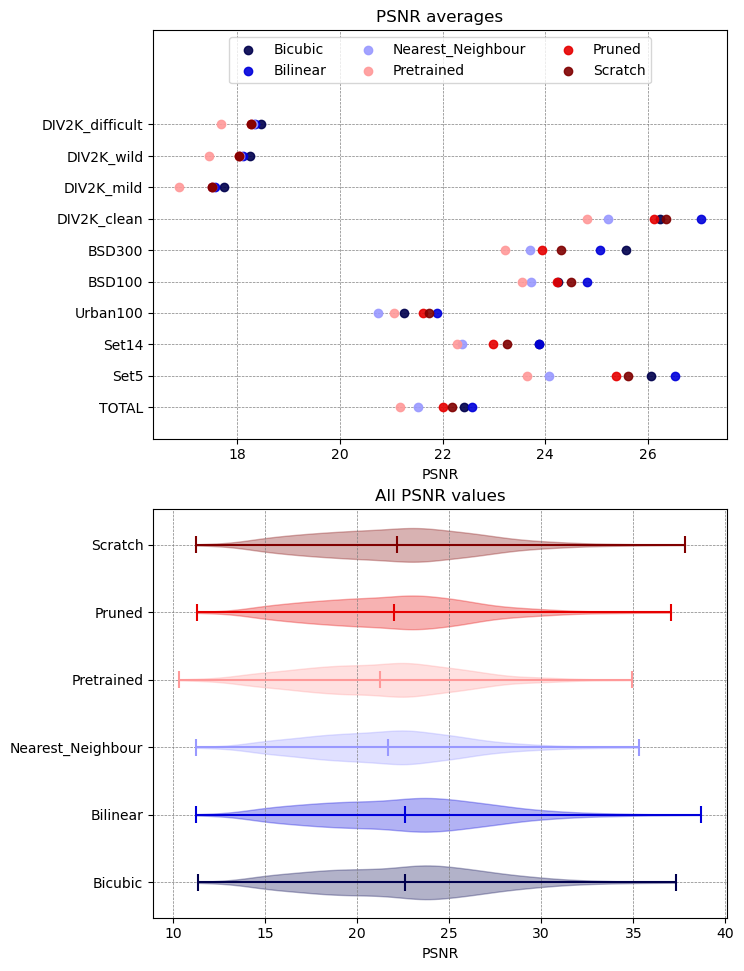

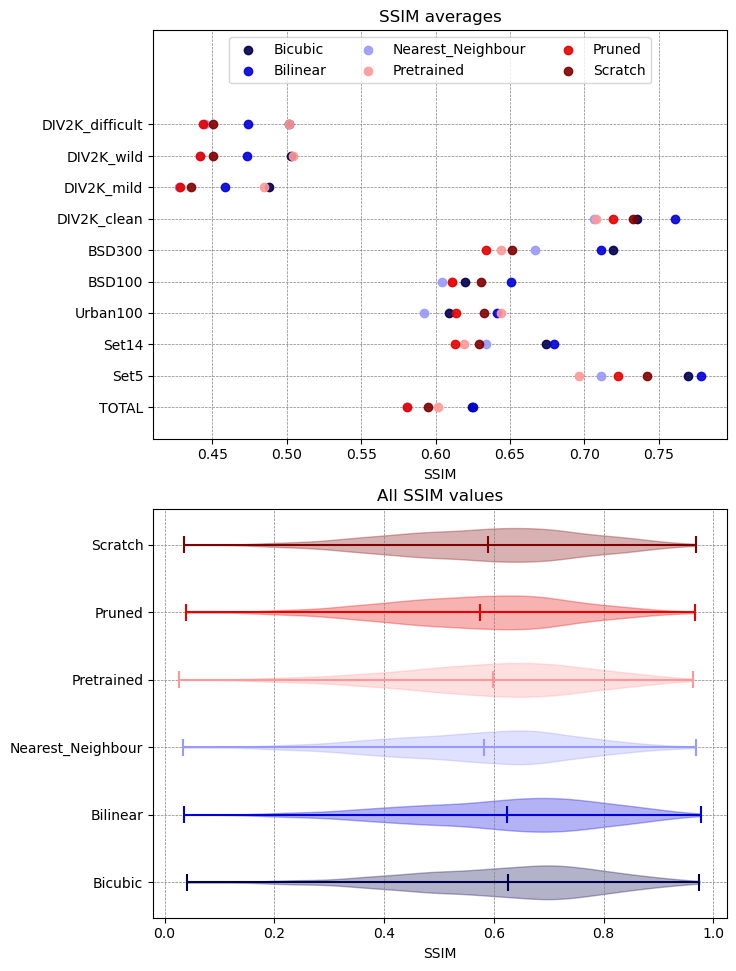

In [19]:
results.visualize()

C:\Users\Vincent\AppData\Local\Temp\ipykernel_18768\442802663.py:201: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(['TOTAL'] + DATASETS)
C:\Users\Vincent\AppData\Local\Temp\ipykernel_18768\442802663.py:210: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(self.method_names)


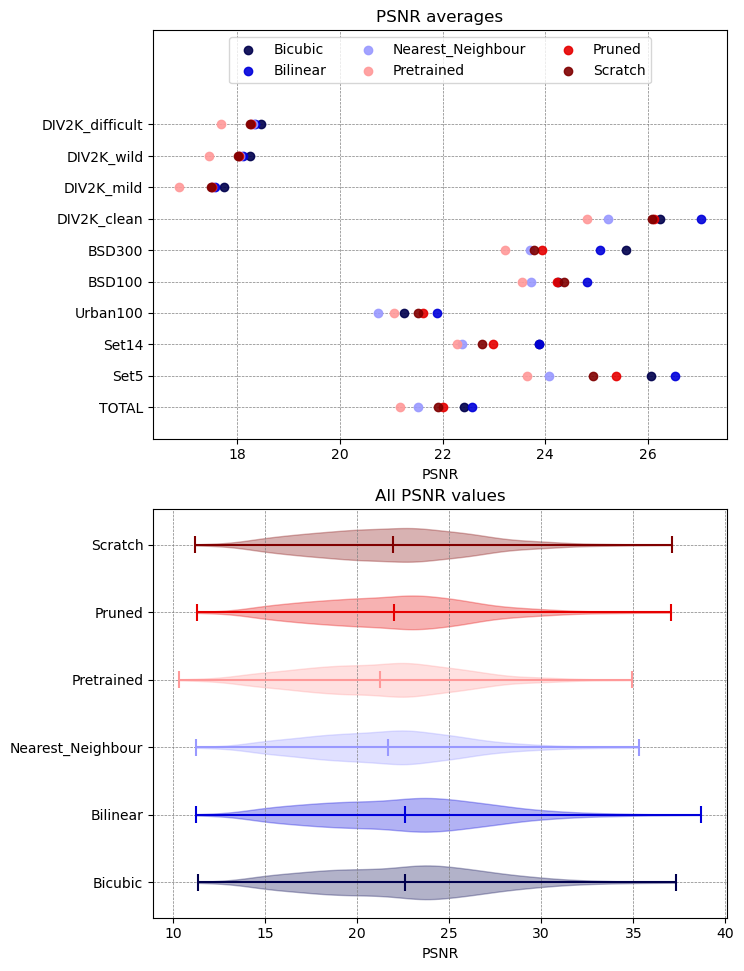

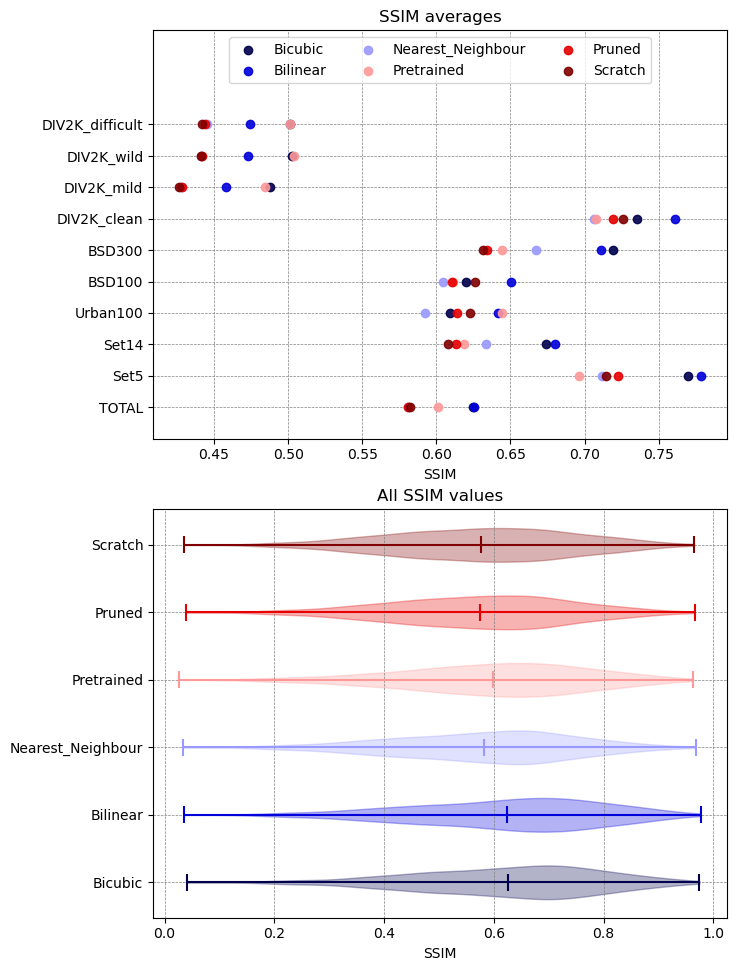

In [34]:
results.visualize()

C:\Users\Vincent\AppData\Local\Temp\ipykernel_35560\739523760.py:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[tmp].set_yticklabels(names)
C:\Users\Vincent\AppData\Local\Temp\ipykernel_35560\739523760.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(compared_on_names)


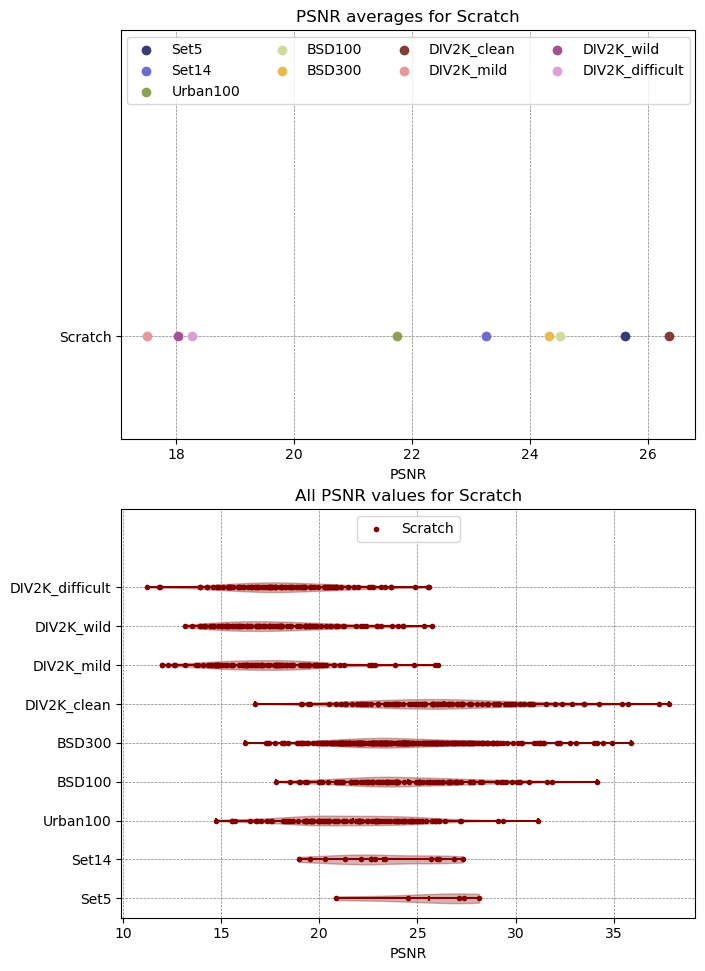

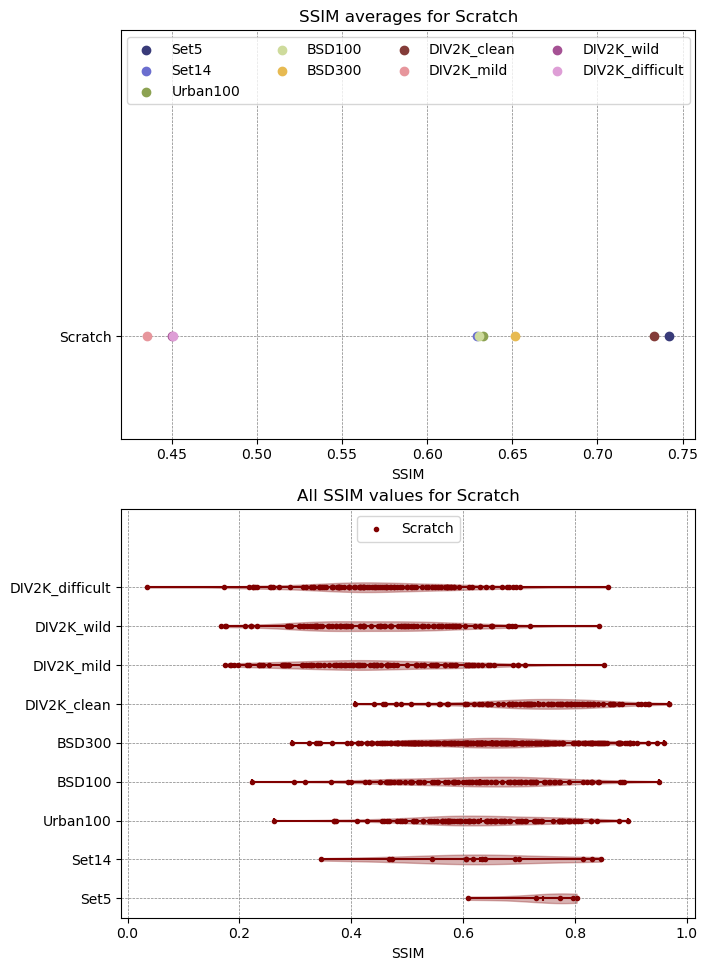

In [20]:
results.method_visualization(5)

C:\Users\Vincent\AppData\Local\Temp\ipykernel_18768\442802663.py:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[tmp].set_yticklabels(names)
C:\Users\Vincent\AppData\Local\Temp\ipykernel_18768\442802663.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(compared_on_names)


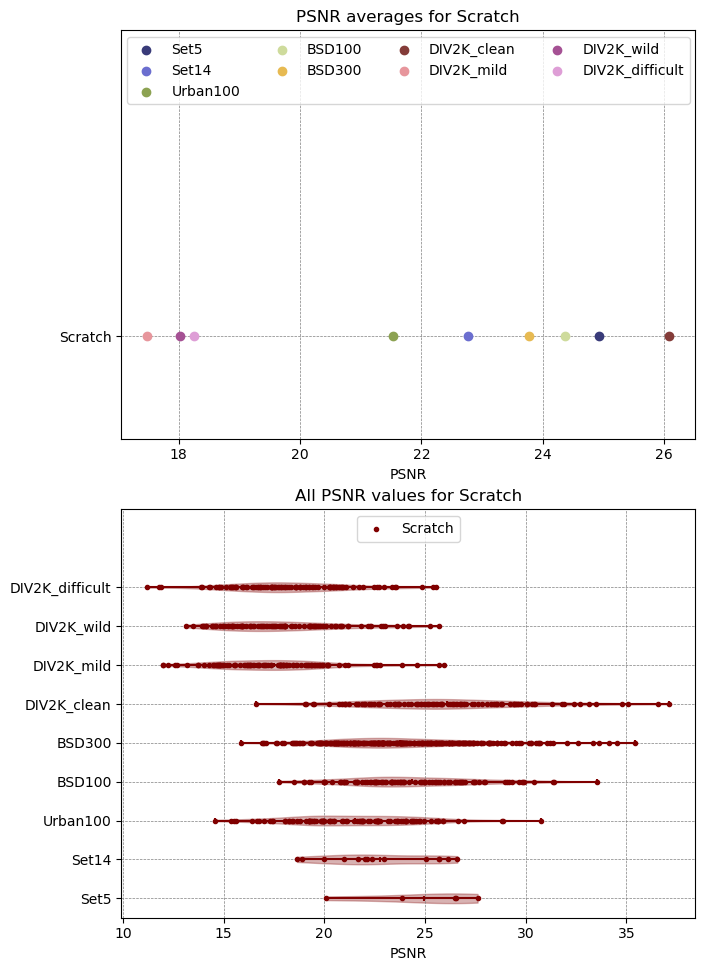

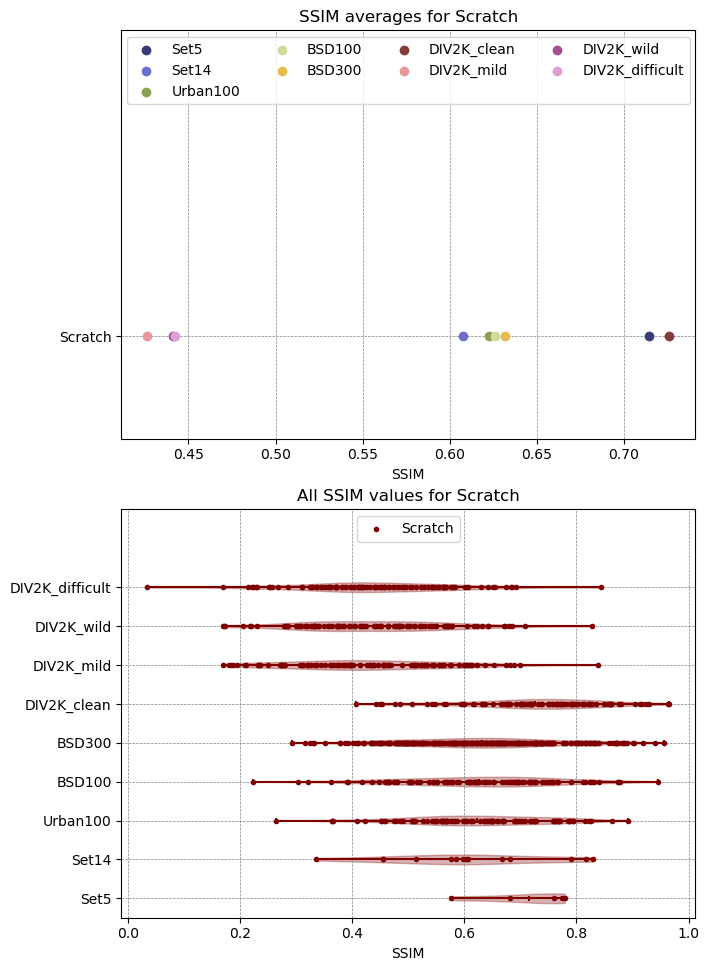

In [35]:
results.method_visualization(5)

In [22]:
import cv2
targets = listdir('D:\Downloads\Set5')
psnrs = [[],[]]
for i,f in enumerate(listdir(r'E:\Images\Super-resolution\Bilinear\Set5')):
    img1 = cv2.imread(f'E:\Images\Super-resolution\Bilinear\Set5\{f}')
    img2 = cv2.imread(f'E:\Images\Super-resolution\Scratch\Set5\{f}')
    img_t = cv2.imread(f'D:\Downloads\Set5\{targets[i]}')

    psnr1 = cv2.PSNR(img1, img_t)
    psnr2 = cv2.PSNR(img2, img_t)
    
    psnrs[0].append(psnr1)
    psnrs[1].append(psnr2)

    print(f'{psnr1:.3f} - {psnr2:.3f}')
print(sum(psnrs[0])/len(psnrs[0]), sum(psnrs[1])/len(psnrs[1]))

30.296 - 28.135
28.142 - 27.138
20.623 - 20.858
28.520 - 27.383
25.010 - 24.544
26.518355507618896 25.61153532493578


- (REMEMBER: we are aiming for similarity, not clearness)
- (Put everything into report, readable for ordinary CS people)
- Print the difference between images

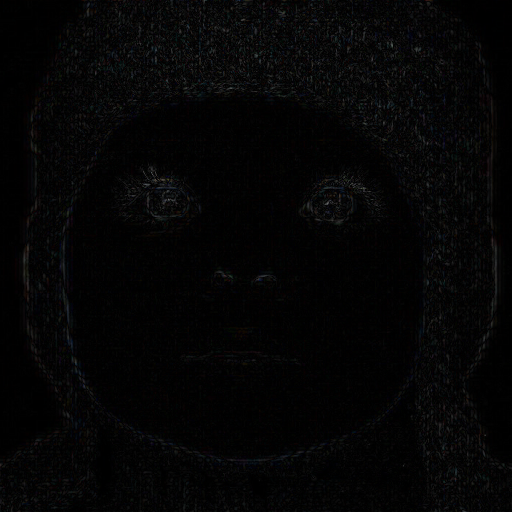

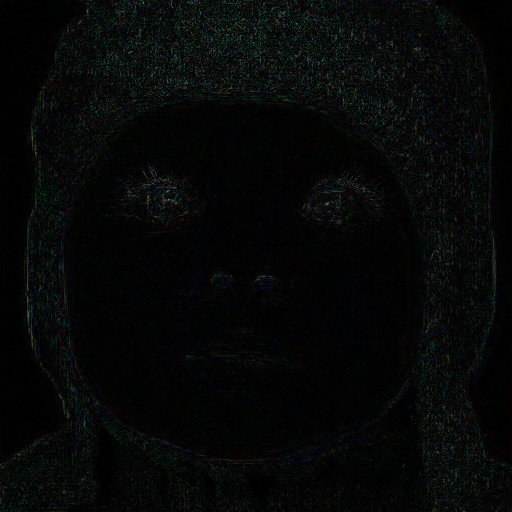

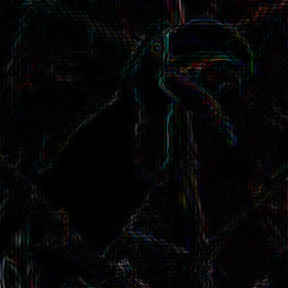

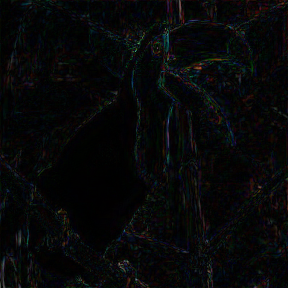

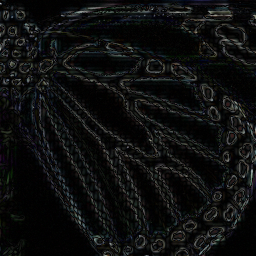

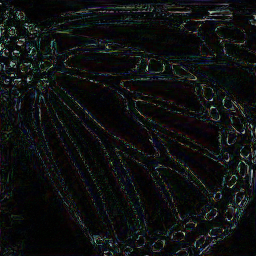

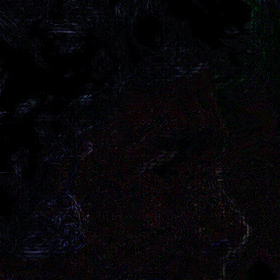

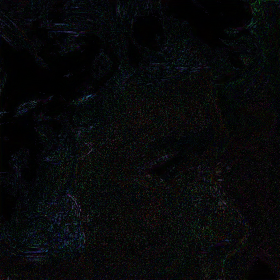

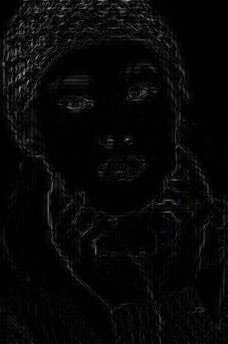

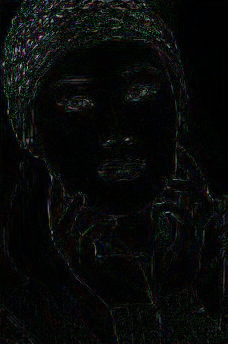

In [36]:
import cv2
targets = listdir('D:\Downloads\Set5')

for i,f in enumerate(listdir(r'E:\Images\Super-resolution\Bilinear\Set5')):
    img1 = cv2.imread(f'E:\Images\Super-resolution\Bilinear\Set5\{f}')
    img2 = cv2.imread(f'E:\Images\Super-resolution\Scratch\Set5\{f}')
    img_t = cv2.imread(f'D:\Downloads\Set5\{targets[i]}')

    display(Image.fromarray(cv2.absdiff(img1,img_t)))
    display(Image.fromarray(cv2.absdiff(img2,img_t)))
    

In [37]:
20*np.log10(1./.03)

30.45757490560675